# Pendulum

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    \theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    \tau
    \end{bmatrix}
\end{equation*}
$$

The goal is to swing the pendulum upright:
$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    \pi & 0
    \end{bmatrix}
\end{equation*}
$$

**Note**: The force is constrained between $-2.5$ and $2.5$ Nm.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pddp
import pddp.examples

In [5]:
import torch
import numpy as np

In [6]:
DT = 0.1  # Time step (s).
N = 40  # Horizon length.
RENDER = True  # Whether to render the environment or not.

# Disable uncertainty since we are dealing with known dynamics.
ENCODING = pddp.StateEncoding.IGNORE_UNCERTAINTY

In [7]:
cost = pddp.examples.pendulum.PendulumCost()
model = pddp.examples.pendulum.PendulumDynamicsModel(DT)
env = pddp.examples.pendulum.PendulumEnv(dt=DT, render=RENDER)

In [8]:
def plot(Z, U):
    t = np.arange(N + 1) * DT
    X = pddp.utils.encoding.decode_mean(Z, ENCODING).detach().numpy()
    U = model.constrain(U).detach().numpy()

    theta = np.unwrap(X[:, 0])  # Makes for smoother plots.
    theta_dot = X[:, 1]
    
    plt.figure()
    plt.plot(theta, theta_dot)
    plt.xlabel("Orientation (rad)")
    plt.ylabel("Angular velocity (rad/s)")
    plt.title("Orientation Phase Plot")

    plt.figure()
    plt.plot(t, theta)
    plt.xlabel("Time (s)")
    plt.ylabel("Orientation (rad)")
    plt.title("Orientation path")

    plt.figure()
    plt.plot(t, theta_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Angular velocity (rad / s)")
    plt.title("Angular velocity path")
    
    plt.figure()
    plt.plot(t[:-1], U)
    plt.xlabel("Time (s)")
    plt.ylabel("Torque (N m)")
    plt.title("Constrained action path")
    
    plt.figure()
    plt.plot(J_hist)
    plt.xlabel("Iteration")
    plt.ylabel("Total loss")
    plt.title("Loss path")

In [9]:
def on_iteration(iteration, Z, U, J_opt, accepted, converged):
    J_opt = J_opt.detach().numpy()

    J_hist.append(J_opt)
    info = "CONVERGED" if converged else ("accepted" if accepted else "FAILED")
    final_state = Z[-1].detach().numpy()
    final_state[0] = (final_state[0] + np.pi) % (2 * np.pi) - np.pi
    print("iteration", iteration + 1, info, J_opt, final_state)

In [10]:
controller = pddp.controllers.PDDPController(env, model, cost)

In [11]:
U = torch.randn(N, model.action_size)

In [12]:
J_hist = []
controller.eval()
Z, U = controller.fit(U, encoding=ENCODING, n_iterations=200,
                      on_iteration=on_iteration)

iteration 1 accepted 669.5061 [-1.3764771 -1.5542789]
iteration 2 accepted 603.97784 [-1.2613161  1.282528 ]
iteration 10 accepted 391.96198 [-2.1392992  -0.05157506]
iteration 11 accepted 356.6227 [-2.1906314  0.0096103]
iteration 12 accepted 322.8944 [-2.208011   -0.01620853]
iteration 13 accepted 302.49026 [-2.238293   -0.12893331]
iteration 14 accepted 261.58054 [-2.4301183  -0.42872763]
iteration 15 accepted 226.55815 [-2.631684   -0.29997158]
iteration 16 accepted 222.37561 [-2.6304884 -0.296152 ]
iteration 17 accepted 207.24506 [-2.6607907  -0.24012303]
iteration 18 accepted 203.58507 [-2.6505518  -0.21714365]
iteration 19 accepted 193.09819 [-2.663871   -0.12811255]
iteration 20 accepted 191.0907 [-2.6589017  -0.09614074]
iteration 21 accepted 187.79272 [-2.689423  -0.0490799]
iteration 22 accepted 186.51562 [-2.6969852  -0.03721619]
iteration 23 accepted 184.77065 [-2.7233791 -0.0194633]
iteration 24 accepted 183.40479 [-2.7355504  -0.01025546]
iteration 25 accepted 181.96318 

iteration 141 accepted 153.04126 [-3.0596282e+00 -9.8466873e-04]
iteration 142 accepted 152.93013 [-3.060927e+00 -9.611249e-04]
iteration 143 accepted 152.85298 [-3.0608172e+00 -9.5635653e-04]
iteration 144 accepted 152.78746 [-3.0614295e+00 -9.4342232e-04]
iteration 145 accepted 152.7367 [-3.0615711e+00 -9.3740225e-04]
iteration 146 accepted 152.66803 [-3.0627322e+00 -9.2577934e-04]
iteration 147 accepted 152.57484 [-3.0626066e+00 -9.2500448e-04]
iteration 148 accepted 152.5006 [-3.0638478e+00 -9.1004372e-04]
iteration 149 accepted 152.42061 [-3.0634041e+00 -9.1314316e-04]
iteration 150 accepted 152.37183 [-3.0637784e+00 -9.0515614e-04]
iteration 151 accepted 152.26997 [-3.0653758e+00 -9.0169907e-04]
iteration 152 accepted 152.21683 [-3.0652671e+00 -8.9275837e-04]
iteration 153 accepted 152.1624 [-3.0657053e+00 -8.7332726e-04]
iteration 154 accepted 152.12161 [-3.0658431e+00 -8.6688995e-04]
iteration 155 accepted 152.04933 [-3.0668325e+00 -8.5127354e-04]
iteration 156 accepted 151.981

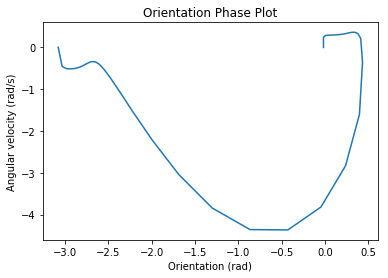

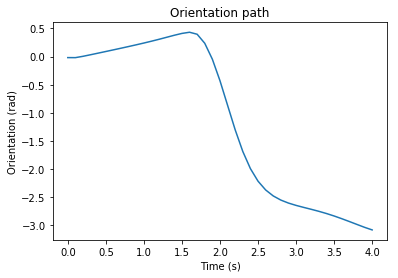

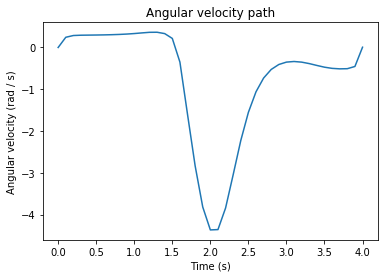

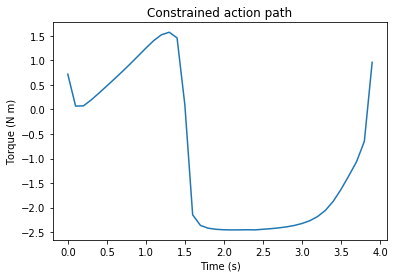

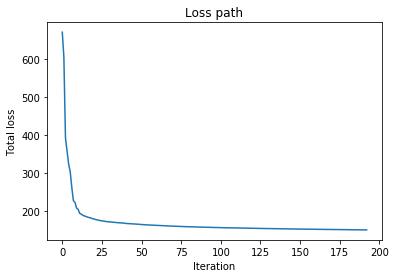

In [13]:
plot(Z, U)

In [14]:
if RENDER:
    # Wait for user interaction before visualizing. 
    _ = input("Press ENTER to continue")

Press ENTER to continue


In [15]:
for u in U:
    env.apply(u)

In [16]:
env.close()